# Importando módulos 

In [228]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from IPython.display import HTML
from IPython import display

# Inputs e Outputs

In [7]:
FOLDER_OUTPUT = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED_old/"

METADATA_OUTPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/METADATA/"

filename_csv = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

# Extraindo informações dos arquivos ".mseed"

In [8]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [9]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling_rate = st[0].stats.sampling_rate
    npts = st[0].stats.npts

    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime],[sampling_rate],[npts]], index=['filename_mseed', 'mergulho', 'stream_number','starttime','endtime','sampling_rate','npts']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [10]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████| 124247/124247 [08:29<00:00, 243.97it/s]


In [11]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [18]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')


In [19]:
dataframe_mseed_final.sort_values(by='starttime')

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts
3,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994
6,pa0001au_002_151112_135041,0001,002,2015-11-12 13:50:41,2015-11-12 13:52:40.930,100.0,11994
4,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994
2,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994
17,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980,100.0,1999
...,...,...,...,...,...,...,...
124239,pa0296au_008_211104_061338,0296,008,2021-11-04 06:13:38,2021-11-04 06:23:37.990,100.0,60000
124241,pa0296au_009_211104_062338,0296,009,2021-11-04 06:23:38,2021-11-04 06:33:37.990,100.0,60000
124240,pa0296au_010_211104_063338,0296,010,2021-11-04 06:33:38,2021-11-04 06:43:37.990,100.0,60000
124242,pa0296au_011_211104_064338,0296,011,2021-11-04 06:43:38,2021-11-04 06:53:37.990,100.0,60000


In [20]:
dataframe_mseed_final['date'] = dataframe_mseed_final['starttime'].dt.date

In [21]:
dataframe_mseed_final

,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,date
0,pa0002au_001_151112_143618,0002,001,2015-11-12 14:36:18,2015-11-12 14:38:17.930,100.0,11994,2015-11-12
1,pa0002au_004_151112_144218,0002,004,2015-11-12 14:42:18,2015-11-12 14:44:17.930,100.0,11994,2015-11-12
2,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,2015-11-12
3,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,2015-11-12
4,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994,2015-11-12
...,...,...,...,...,...,...,...,...
124242,pa0296au_011_211104_064338,0296,011,2021-11-04 06:43:38,2021-11-04 06:53:37.990,100.0,60000,2021-11-04
124243,pa0296au_005_211104_054338,0296,005,2021-11-04 05:43:38,2021-11-04 05:53:37.990,100.0,60000,2021-11-04
124244,pa0296au_007_211104_060338,0296,007,2021-11-04 06:03:38,2021-11-04 06:13:37.990,100.0,60000,2021-11-04
124245,pa0296au_004_211104_053338,0296,004,2021-11-04 05:33:38,2021-11-04 05:43:37.990,100.0,60000,2021-11-04


# Extraindo informações dos arquivos ".csv"

In [108]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [109]:
df_csv = dataframe_csv.groupby("filename").agg(pd.Series.tolist)

In [110]:
df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')

In [111]:
df_csv.sort_values(by='time')

,time,latitude,longitude,depth,filename_mseed
filename,,,,,
pa0001au_001_151112_134841_rms_spl3.mat,"[2015-11-12 13:48:40.999995, 2015-11-12 13:49:...","[-23.825157, -23.82495]","[-42.495483, -42.495487]","[1.3142858, 7.4155555]",pa0001au_001_151112_134841
pa0001au_002_151112_135041_rms_spl3.mat,"[2015-11-12 13:50:40.999998, 2015-11-12 13:51:...","[-23.824745, -23.82454]","[-42.49549, -42.495495]","[15.776, 24.372]",pa0001au_002_151112_135041
pa0001au_003_151112_135241_rms_spl3.mat,"[2015-11-12 13:52:41.000001, 2015-11-12 13:53:...","[-23.824331, -23.824125]","[-42.4955, -42.495502]","[32.912, 41.34]",pa0001au_003_151112_135241
pa0001au_004_151112_135441_rms_spl3.mat,"[2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]","[-23.82392, -23.823713]","[-42.495506, -42.495506]","[48.91, 52.824]",pa0001au_004_151112_135441
pa0002au_001_151112_143618_rms_spl3.mat,"[2015-11-12 14:36:17.999998, 2015-11-12 14:37:...","[-23.817575, -23.81744]","[-42.49506, -42.494965]","[1.4671428, 9.36]",pa0002au_001_151112_143618
...,...,...,...,...,...
pa0296au_008_211104_061338_rms_spl3.mat,"[2021-11-04 06:13:37.999999, 2021-11-04 06:14:...","[-24.457632, -24.457657, -24.457726, -24.45786...","[-42.470257, -42.470303, -42.470325, -42.47033...","[550.4096, 559.3073, 567.8462, 575.10706, 582....",pa0296au_008_211104_061338
pa0296au_009_211104_062338_rms_spl3.mat,"[2021-11-04 06:23:38.000003, 2021-11-04 06:24:...","[-24.458628, -24.458672, -24.45872, -24.458822...","[-42.47047, -42.470528, -42.470562, -42.470573...","[629.96436, 637.68353, 646.56323, 654.6224, 66...",pa0296au_009_211104_062338
pa0296au_010_211104_063338_rms_spl3.mat,"[2021-11-04 06:33:37.999998, 2021-11-04 06:34:...","[-24.459415, -24.459513, -24.45957, -24.45963,...","[-42.4708, -42.470802, -42.470856, -42.4709, -...","[706.7263, 715.5506, 722.5956, 730.11316, 737....",pa0296au_010_211104_063338


In [112]:
def name_to_mergulho_stream(filename):
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]

    if 'pa' in filename.split('_')[2]:
        mergulho = filename.split('_')[2].split('a')[1]
    
    return mergulho

In [113]:
def calcular_media(lista):
    if len(lista) == 0:
        return None  # Retorna None se a lista estiver vazia para evitar erros
    else:
        return pd.Series(lista).mean()

In [135]:
def flatten(l):
    return l[0]

In [115]:
df_csv['mergulho'] = df_csv['filename_mseed'].apply(name_to_mergulho_stream)

In [116]:
df_csv['date'] = df_csv['time'].apply(calcular_media).dt.date

In [128]:
df_csv

,time,latitude,longitude,depth,filename_mseed,mergulho,date,lat,lon,dep
filename,,,,,,,,,,
160708_172008_pa0003au_001_rms_spl3.mat,2016-07-08 17:20:07.999999,"[-24.391026, -24.391314, -24.391335]","[-43.821663, -43.82173, -43.82174]","[0.9987981, 9.891874, 10.969999]",160708_172008_pa0003au_001,0003,2016-07-08,-24.391225,-43.821711,7.286890
160708_172307_pa0003au_002_rms_spl3.mat,2016-07-08 17:23:07.000004,"[-24.391356, -24.3916, -24.391617]","[-43.821743, -43.8218, -43.821804]","[12.030156, 23.590548, 24.420235]",160708_172307_pa0003au_002,0003,2016-07-08,-24.391524,-43.821782,20.013646
160708_172607_pa0003au_003_rms_spl3.mat,2016-07-08 17:26:07.000003,"[-24.391909, -24.39193, -24.392172]","[-43.821873, -43.82188, -43.821938]","[36.456642, 37.333202, 47.245785]",160708_172607_pa0003au_003,0003,2016-07-08,-24.392004,-43.821897,40.345210
160708_172906_pa0003au_004_rms_spl3.mat,2016-07-08 17:29:05.999998,"[-24.392193, -24.392475, -24.392496]","[-43.82194, -43.822006, -43.82201]","[48.01094, 58.52969, 59.289062]",160708_172906_pa0003au_004,0003,2016-07-08,-24.392388,-43.821985,55.276564
160708_173205_pa0003au_005_rms_spl3.mat,2016-07-08 17:32:05.000003,"[-24.392744, -24.392765, -24.393057]","[-43.822067, -43.822075, -43.822144]","[68.57156, 69.49031, 80.89149]",160708_173205_pa0003au_005,0003,2016-07-08,-24.392855,-43.822095,72.984453
...,...,...,...,...,...,...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,2016-04-18 07:52:02.000001,"[-24.46632, -24.466305]","[-43.148865, -43.14886]","[897.4117, 899.9383]",pa0626au_041_160418_075202,0626,2016-04-18,-24.466313,-43.148862,898.675000
pa0626au_042_160418_075402_rms_spl3.mat,2016-04-18 07:54:02.000004,"[-24.466183, -24.466167]","[-43.14885, -43.148846]","[918.85736, 921.4589]",pa0626au_042_160418_075402,0626,2016-04-18,-24.466175,-43.148848,920.158130
pa0626au_043_160418_075602_rms_spl3.mat,2016-04-18 07:56:01.999997,"[-24.466047, -24.466032]","[-43.148834, -43.14883]","[940.0661, 942.0864]",pa0626au_043_160418_075602,0626,2016-04-18,-24.466040,-43.148832,941.076250


In [118]:
df_csv['lat'] =  df_csv['latitude'].apply(calcular_media)
df_csv['lon'] =  df_csv['longitude'].apply(calcular_media)
df_csv['dep'] =  df_csv['depth'].apply(calcular_media)
df_csv['time'] =  df_csv['time'].apply(flatten)

In [119]:
df_csv_mean = df_csv.drop(columns=['latitude','longitude','depth',])

In [129]:
df_csv_mean

,time,filename_mseed,mergulho,date,lat,lon,dep
filename,,,,,,,
160708_172008_pa0003au_001_rms_spl3.mat,2016-07-08 17:20:07.999999,160708_172008_pa0003au_001,0003,2016-07-08,-24.391225,-43.821711,7.286890
160708_172307_pa0003au_002_rms_spl3.mat,2016-07-08 17:23:07.000004,160708_172307_pa0003au_002,0003,2016-07-08,-24.391524,-43.821782,20.013646
160708_172607_pa0003au_003_rms_spl3.mat,2016-07-08 17:26:07.000003,160708_172607_pa0003au_003,0003,2016-07-08,-24.392004,-43.821897,40.345210
160708_172906_pa0003au_004_rms_spl3.mat,2016-07-08 17:29:05.999998,160708_172906_pa0003au_004,0003,2016-07-08,-24.392388,-43.821985,55.276564
160708_173205_pa0003au_005_rms_spl3.mat,2016-07-08 17:32:05.000003,160708_173205_pa0003au_005,0003,2016-07-08,-24.392855,-43.822095,72.984453
...,...,...,...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,2016-04-18 07:52:02.000001,pa0626au_041_160418_075202,0626,2016-04-18,-24.466313,-43.148862,898.675000
pa0626au_042_160418_075402_rms_spl3.mat,2016-04-18 07:54:02.000004,pa0626au_042_160418_075402,0626,2016-04-18,-24.466175,-43.148848,920.158130
pa0626au_043_160418_075602_rms_spl3.mat,2016-04-18 07:56:01.999997,pa0626au_043_160418_075602,0626,2016-04-18,-24.466040,-43.148832,941.076250


In [136]:
df_mergulho = df_csv_mean.groupby(["date", "mergulho"]).agg(pd.Series.tolist)

In [137]:
df_mergulho.sort_values(by='date')

time  \
date       mergulho                                                      
2015-11-12 0001      [2015-11-12 13:48:40.999995, 2015-11-12 13:50:...   
           0002      [2015-11-12 14:36:17.999998, 2015-11-12 14:38:...   
           0003      [2015-11-12 15:35:47.999997, 2015-11-12 15:37:...   
           0004      [2015-11-12 17:42:06.999996, 2015-11-12 17:44:...   
           0005      [2015-11-12 20:43:35.999996, 2015-11-12 20:45:...   
...                                                                ...   
2021-11-02 0288      [2021-11-02 12:40:25.000003, 2021-11-02 12:50:...   
2021-11-03 0291      [2021-11-03 03:38:04.000003, 2021-11-03 03:48:...   
           0292      [2021-11-03 09:16:41.000002, 2021-11-03 09:26:...   
2021-11-04 0295      [2021-11-04 00:25:55.999999, 2021-11-04 00:35:...   
           0296      [2021-11-04 05:03:37.999998, 2021-11-04 05:13:...   

                                                        filename_mseed  \
date       mergulho                                                      
2015-11-12 0001      [pa0001au_001_151112_134841, pa0001au_002_1511...   
           0002      [pa0002au_001_151112_143618, pa0002au_002_1511...   
           0003      [pa0003au_001_151112_153548, pa0003au_002_1511...   
           0004      [pa0004au_001_151112_174207, pa0004au_002_1511...   
           0005      [pa0005au_001_151112_204336, pa0005au_002_1511...   
...                                                                ...   
2021-11-02 0288      [pa0288au_001_211102_124025, pa0288au_002_2111...   
2021-11-03 0291      [pa0291au_001_211103_033804, pa0291au_002_2111...   
           0292      [pa0292au_001_211103_091641, pa0292au_002_2111...   
2021-11-04 0295      [pa0295au_001_211104_002556, pa0295au_002_2111...   
           0296      [pa0296au_001_211104_050338, pa0296au_002_2111...   

                                                                   lat  \
date       mergulho                                                      
2015-11-12 0001      [-23.825053500000003, -23.8246425, -23.8242279...   
           0002      [-23.8175075, -23.817236, -23.816964, -23.8166...   
           0003      [-23.8102255, -23.809901, -23.809576, -23.8092...   
           0004      [-23.791143499999997, -23.791131, -23.79111850...   
           0005      [-23.7855565, -23.785538, -23.7855195, -23.785...   
...                                                                ...   
2021-11-02 0288      [-24.3308765, -24.331216700000002, -24.3315312...   
2021-11-03 0291      [-24.3488883, -24.3499197, -24.3510136, -24.35...   
           0292      [-24.3730066, -24.373596600000006, -24.3742725...   
2021-11-04 0295      [-24.4330778, -24.433873400000003, -24.4346555...   
           0296      [-24.4520911, -24.4530278, -24.4540274, -24.45...   

                                                                   lon  \
date       mergulho                                                      
2015-11-12 0001      [-42.495485, -42.4954925, -42.495501000000004,...   
           0002      [-42.4950125, -42.4948155, -42.494619, -42.494...   
           0003      [-42.490898, -42.490516, -42.490133, -42.48975...   
           0004      [-42.474413, -42.4743435, -42.474274, -42.4742...   
           0005      [-42.470098, -42.470031500000005, -42.469965, ...   
...                                                                ...   
2021-11-02 0288      [-42.4342379, -42.4343096, -42.434333800000005...   
2021-11-03 0291      [-42.423682, -42.423715099999995, -42.42402259...   
           0292      [-42.4287757, -42.4289428, -42.42958409999999,...   
2021-11-04 0295      [-42.4643029, -42.4644099, -42.464621699999995...   
           0296      [-42.4683766, -42.468583699999996, -42.4688643...   

                                                                   dep  
date       mergulho                                                     
2015-11-12 0001      [4.36492065, 20.073999999999998, 37.1260000000.

In [138]:
df_mergulho['lat'] =  df_mergulho['lat'].apply(calcular_media)
df_mergulho['lon'] =  df_mergulho['lon'].apply(calcular_media)
df_mergulho['dep'] =  df_mergulho['dep'].apply(calcular_media)
df_mergulho['time'] =  df_mergulho['time'].apply(flatten)

In [139]:
df_mergulho_feather = df_mergulho.reset_index()

In [147]:
df_mergulho_feather['date_nettab'] = df_mergulho_feather['time'].dt.strftime('%Y/%j[:%H%M]')

In [149]:
df_mergulho_feather['station_nettab'] = df_mergulho_feather['time'].dt.strftime('G%H%M')

In [150]:
df_mergulho_feather

,date,mergulho,time,filename_mseed,lat,lon,dep,date_nettab,station_nettab
0,2015-11-12,0001,2015-11-12 13:48:40.999995,"[pa0001au_001_151112_134841, pa0001au_002_1511...",-23.824435,-42.495496,28.107980,2015/316[:1348],G1348
1,2015-11-12,0002,2015-11-12 14:36:17.999998,"[pa0002au_001_151112_143618, pa0002au_002_1511...",-23.816693,-42.494423,54.389724,2015/316[:1436],G1436
2,2015-11-12,0003,2015-11-12 15:35:47.999997,"[pa0003au_001_151112_153548, pa0003au_002_1511...",-23.807137,-42.487275,159.719170,2015/316[:1535],G1535
3,2015-11-12,0004,2015-11-12 17:42:06.999996,"[pa0004au_001_151112_174207, pa0004au_002_1511...",-23.790957,-42.473373,264.914544,2015/316[:1742],G1742
4,2015-11-12,0005,2015-11-12 20:43:35.999996,"[pa0005au_001_151112_204336, pa0005au_002_1511...",-23.785264,-42.469056,283.000283,2015/316[:2043],G2043
...,...,...,...,...,...,...,...,...,...
4113,2021-11-02,0288,2021-11-02 12:40:25.000003,"[pa0288au_001_211102_124025, pa0288au_002_2111...",-24.334206,-42.434063,490.726565,2021/306[:1240],G1240
4114,2021-11-03,0291,2021-11-03 03:38:04.000003,"[pa0291au_001_211103_033804, pa0291au_002_2111...",-24.356838,-42.425637,509.938108,2021/307[:0338],G0338
4115,2021-11-03,0292,2021-11-03 09:16:41.000002,"[pa0292au_001_211103_091641, pa0292au_002_2111...",-24.378415,-42.430636,500.532732,2021/307[:0916],G0916
4116,2021-11-04,0295,2021-11-04 00:25:55.999999,"[pa0295au_001_211104_002556, pa0295au_002_2111...",-24.437741,-42.464982,460.269513,2021/308[:0025],G0025


In [167]:
# Montando a tabela com os nome dos gliders:

glider_information_dic = {
'name':['SG618',
'SG618',
'SG612',
'SG612',
'SG612',
'SG612',
'SG612',
'SG612',
'SG612',
'SG569',
'SG570',
'SG571',
'SG612',
'SG612',
'SG612',
'SG571',
'SG612',
'SG612',
'SG612',
'SG612',
'SG612',
'SG657',
'SG656',
'SG657',
'SG657',
'SG657',
'SG656',
'SG656',
'SG657',
'SG656',
'SG657',
'SG657',
'SG657'
],
'start':['10/11/2015',
'08/01/2016',
'02/02/2016',
'07/07/2016',
'16/08/2016',
'16/09/2016',
'21/10/2016',
'20/11/2016',
'14/01/2017',
'17/02/2017',
'24/03/2017',
'03/06/2017',
'12/07/2017',
'17/08/2017',
'04/10/2017',
'29/10/2017',
'10/12/2017',
'20/01/2018',
'22/02/2018',
'22/05/2018',
'06/07/2018',
'29/08/2018',
'03/10/2018',
'13/11/2018',
'28/12/2018',
'10/02/2019',
'23/03/2019',
'29/06/2019',
'19/08/2019',
'04/09/2019',
'15/10/2019',
'02/12/2019',
'02/01/2020'    
],
'end':['20/12/2015',
'02/02/2016',
'20/04/2016',
'16/08/2016',
'16/09/2016',
'15/10/2016',
'20/11/2016',
'11/01/2017',
'16/02/2017',
'24/03/2017',
'30/04/2017',
'12/07/2017',
'16/08/2017',
'04/10/2017',
'28/10/2017',
'09/12/2017',
'20/01/2018',
'22/02/2018',
'05/04/2018',
'06/07/2018',
'22/07/2018',
'03/10/2018',
'14/11/2018',
'23/12/2018',
'05/01/2019',
'14/03/2019',
'01/05/2019',
'31/07/2019',
'28/08/2019',
'10/10/2019',
'30/11/2019',
'31/12/2019',
'11/12/2021'
]}

In [182]:
GL_info = pd.DataFrame.from_dict(glider_information_dic)
GL_info['start'] = pd.to_datetime(GL_info.start, format='%d/%m/%Y')
GL_info['end'] = pd.to_datetime(GL_info.end, format='%d/%m/%Y')

GL_info['start'] = GL_info['start'].dt.date 
GL_info['end'] = GL_info['end'].dt.date 

In [183]:
GL_info

,name,start,end
0,SG618,2015-11-10,2015-12-20
1,SG618,2016-01-08,2016-02-02
2,SG612,2016-02-02,2016-04-20
3,SG612,2016-07-07,2016-08-16
4,SG612,2016-08-16,2016-09-16
5,SG612,2016-09-16,2016-10-15
6,SG612,2016-10-21,2016-11-20
7,SG612,2016-11-20,2017-01-11
8,SG612,2017-01-14,2017-02-16
9,SG569,2017-02-17,2017-03-24


<Axes: xlabel='Modelo', ylabel='Data'>

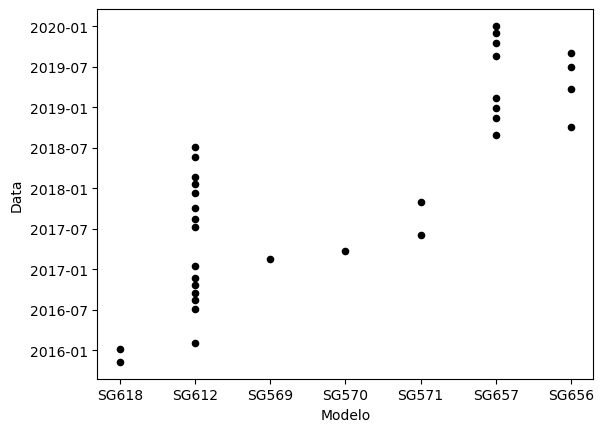

In [225]:
GL_info.plot('name','start','scatter',c='k',ylabel='Data',xlabel='Modelo')

In [227]:
for i in df_mergulho_feather.iterrows():
    # Station lines (one line per station/sensor/epoch) # code description datalogger%sn seismometer%sn # sampling orientation lat. lon. elev. depth. start end
    #Sl: UNAP "Uni-Iquique/Chile"   DM24%A1383 CMG-3ESP/60%T34622 100 ZNE -20.24393 -70.14041 0.0    0.0 2009/134 
    
    # Select DataFrame rows between two dates
    
    filtro = (i[1].date >= GL_info["start"]) & (i[1].date < GL_info["end"])

    # Using pandas.DataFrame.loc to Filter Rows by Dates
    
    df2 = GL_info[filtro]
   
    print(df2)

    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name  

    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name       start         end
0  SG618  2015-11-10  2015-12-20
    name  

    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name       start         end
2  SG612  2016-02-02  2016-04-20
    name  

    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
4  SG612  2016-08-16  2016-09-16
    name       start         end
5  SG612  2016-09-16  2016-10-15
    name  

    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name       start         end
7  SG612  2016-11-20  2017-01-11
    name  

    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
    name       start         end
9  SG569  2017-02-17  2017-03-24
     name 

     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  2017-06-03  2017-07-12
     name       start         end
11  SG571  201

     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  2017-08-17  2017-10-04
     name       start         end
13  SG612  201

     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  2017-10-29  2017-12-09
     name       start         end
15  SG571  201

     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  2017-12-10  2018-01-20
     name       start         end
16  SG612  201

Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [na

     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  2018-07-06  2018-07-22
     name       start         end
20  SG612  201

     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
21  SG657  2018-08-29  2018-10-03
     name       start         end
22  SG656  2018-10-03  2018-11-14
     name       start         end
22  SG656  2018-10-03  2018-11-14
     name       start         end
22  SG656  2018-10-03  2018-11-14
     name       start         end
22  SG656  201

     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  2018-11-13  2018-12-23
     name       start         end
23  SG657  201

Empty DataFrame
Columns: [name, start, end]
Index: []
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-03-14
     name       start         end
25  SG657  2019-02-10  2019-

     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  2019-03-23  2019-05-01
     name       start         end
26  SG656  201

     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
     name       start         end
27  SG656  2019-06-29  2019-07-31
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Columns: [name, start, end]
Index: []
Empty DataFrame
Column

     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  2019-10-15  2019-11-30
     name       start         end
30  SG657  201

     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  202

     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  202

     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  202

     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  202

     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  2020-01-02  2021-12-11
     name       start         end
32  SG657  202

In [211]:
with open('readme.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

for i in df_mergulho_feather.iterrows():
    # Station lines (one line per station/sensor/epoch) # code description datalogger%sn seismometer%sn # sampling orientation lat. lon. elev. depth. start end
    #Sl: UNAP "Uni-Iquique/Chile"   DM24%A1383 CMG-3ESP/60%T34622 100 ZNE -20.24393 -70.14041 0.0    0.0 2009/134 
    
    # Select DataFrame rows between two dates
    
    filtro = (i[1].date > GL_info["start"]) & (i[1].date < GL_info["end"])

    # Using pandas.DataFrame.loc to Filter Rows by Dates
    
    df2 = GL_info[filtro]
   
    print('Sl: '+i[1].station_nettab+' Glider:'+df2['name'].values[0]+' SENSOR'+' '+'REGISTER'+' 100 Z '+str(i[1].lat)+' '+str(i[1].lon)+' 0 0 '+i[1].date_nettab)

Sl: G1348 Glider:SG618 SENSOR REGISTER 100 Z -23.824435125 -42.495496125 0 0 2015/316[:1348]
Sl: G1436 Glider:SG618 SENSOR REGISTER 100 Z -23.816692857142858 -42.49442285714286 0 0 2015/316[:1436]
Sl: G1535 Glider:SG618 SENSOR REGISTER 100 Z -23.807136875 -42.487274625 0 0 2015/316[:1535]
Sl: G1742 Glider:SG618 SENSOR REGISTER 100 Z -23.79095746774194 -42.473372612903226 0 0 2015/316[:1742]
Sl: G2043 Glider:SG618 SENSOR REGISTER 100 Z -23.78526434375 -42.469055937499995 0 0 2015/316[:2043]
Sl: G2359 Glider:SG618 SENSOR REGISTER 100 Z -23.780344 -42.469132 0 0 2015/316[:2359]
Sl: G0001 Glider:SG618 SENSOR REGISTER 100 Z -23.77930183928572 -42.46778675 0 0 2015/317[:0001]
Sl: G0217 Glider:SG618 SENSOR REGISTER 100 Z -23.77339624137931 -42.46528943103448 0 0 2015/317[:0217]
Sl: G0452 Glider:SG618 SENSOR REGISTER 100 Z -23.769867535714287 -42.457230374999995 0 0 2015/317[:0452]
Sl: G0724 Glider:SG618 SENSOR REGISTER 100 Z -23.76878751923077 -42.449432461538464 0 0 2015/317[:0724]
Sl: G0919

IndexError: index 0 is out of bounds for axis 0 with size 0

In [212]:
df_mergulho_feather.to_feather('/home/dIOGOLOC/Documents/df_mergulho.feather')

/home/dIOGOLOC/programs/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


# Plotando o dataframe com os mergulhos: 

/tmp/ipykernel_1010574/1344821389.py:58: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,


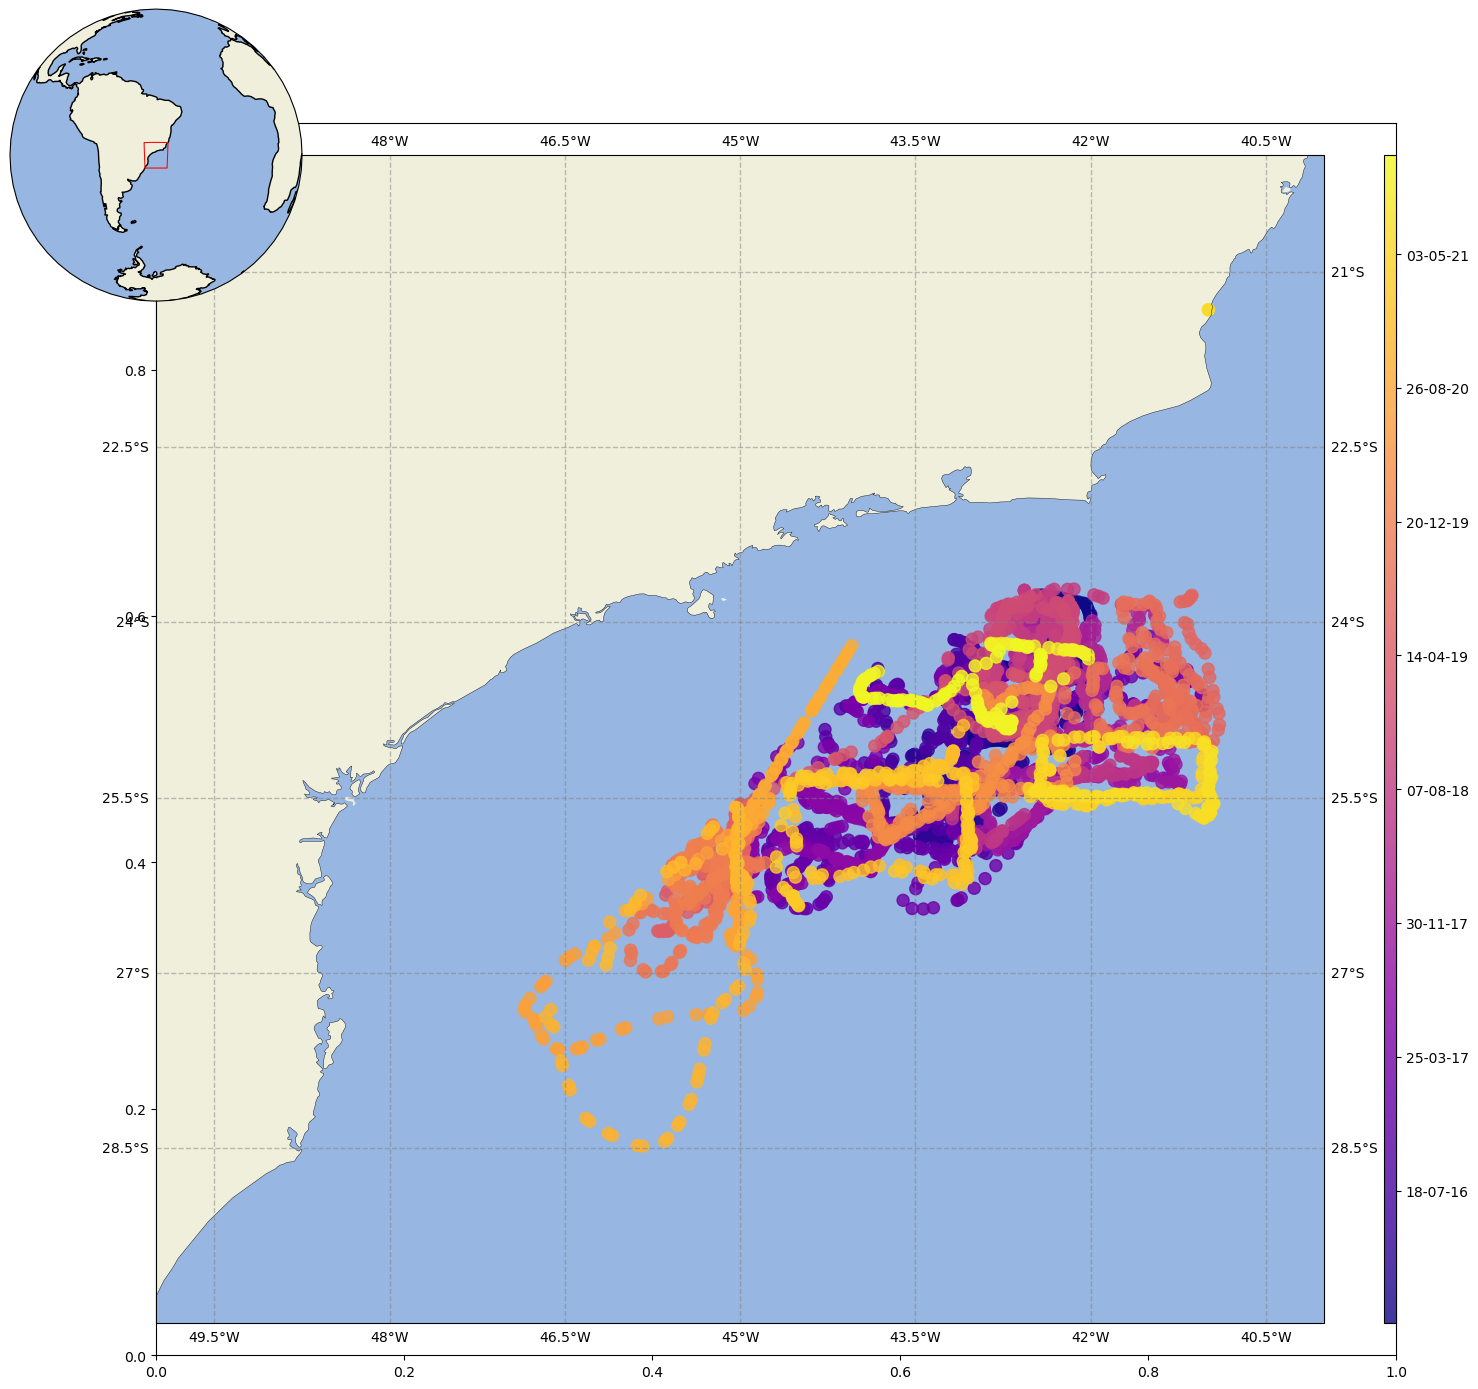

In [219]:

#########################################################################################################################################################
#Figure 

# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,1,figsize=(16,16))
ax = plt.subplot(1, 1, 1, projection=proj)
                    
# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values
                
h = ax.scatter(df_mergulho['lon'].values,df_mergulho['lat'].values,c=np.array([mdates.date2num(i) for i in df_mergulho['time'].values]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)

# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
   
# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.25

# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                          inset_y - inset_size / 2,
                          inset_size,inset_size])
    
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
    
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

        
# ----------------------------------------------------------------------------------------------------------
# Saving figure
#os.makedirs(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/',exist_ok=True)
#fig.savefig(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/'+'interp_mseed_'+file_n_meta+'.png')
#plt.close()

In [ ]:
# set up plotting
fig = plt.figure()
ax = plt.axes()

h = ax.scatter(df_mergulho['lon'].values,df_mergulho['lat'].values,c=np.array([mdates.date2num(i) for i in df_mergulho['time'].values]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)


ax.plot(ttime,tdata,c='k',lw=0.1,alpha=0.3)
line, = ax.plot([],[],c='r', lw=0.5,alpha=0.7)
ax.set_xlim(ttime[0],ttime[-1])
ax.set_ylim(tdata.min(), tdata.max())

ax.set_yticks([])

# methods for animation
def init():
    line.set_data([],[])
    return line,

def animate(i):
    y = wave_to_plot[i]
    x = time_to_plot[i]
    line.set_data(x,y)

    return line,

# Save the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(wave_to_plot))
HTML(anim.to_jshtml())

# Save the animation as an 
f = r"/home/diogoloc/dados_posdoc/ON02_analysis/Figuras/Localizacao_navio_ponte_ON_ON02.mp4" 
writervideo = animation.FFMpegWriter(fps=10) 
anim.save(f, writer=writervideo)
